# Выбор региона для бурения скважин: оценка прибыли и рисков (Bootstrap)

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки.

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
import numpy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Далее, датасет каждого из трех регионов сохраним в отдельную переменную.

In [3]:
data_1 = pd.read_csv(r'datasets\geo_data_0.csv')
data_2 = pd.read_csv(r'datasets\geo_data_1.csv')
data_3 = pd.read_csv(r'datasets\geo_data_2.csv')

Выведем общую информацию о каждом датасете и проверим правильность данных.

In [4]:
data_1.info()
data_2.info()
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Пропуски отсутствуют, названия столбцов соответствуют правильному стандарту написания, верные типы данных в столбцах. Столбец `id` является идентификатором скважины и не несёт полезной информации для обучения модели, поэтому в дальнейшем в анализе и обучении не используется.


Выведем первые строки датасетов.

In [5]:
print(data_1.head())
print(data_2.head())
print(data_3.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


Сами параметры `f1`, `f2` и `f3`в каждом датасете являются неизвестными.

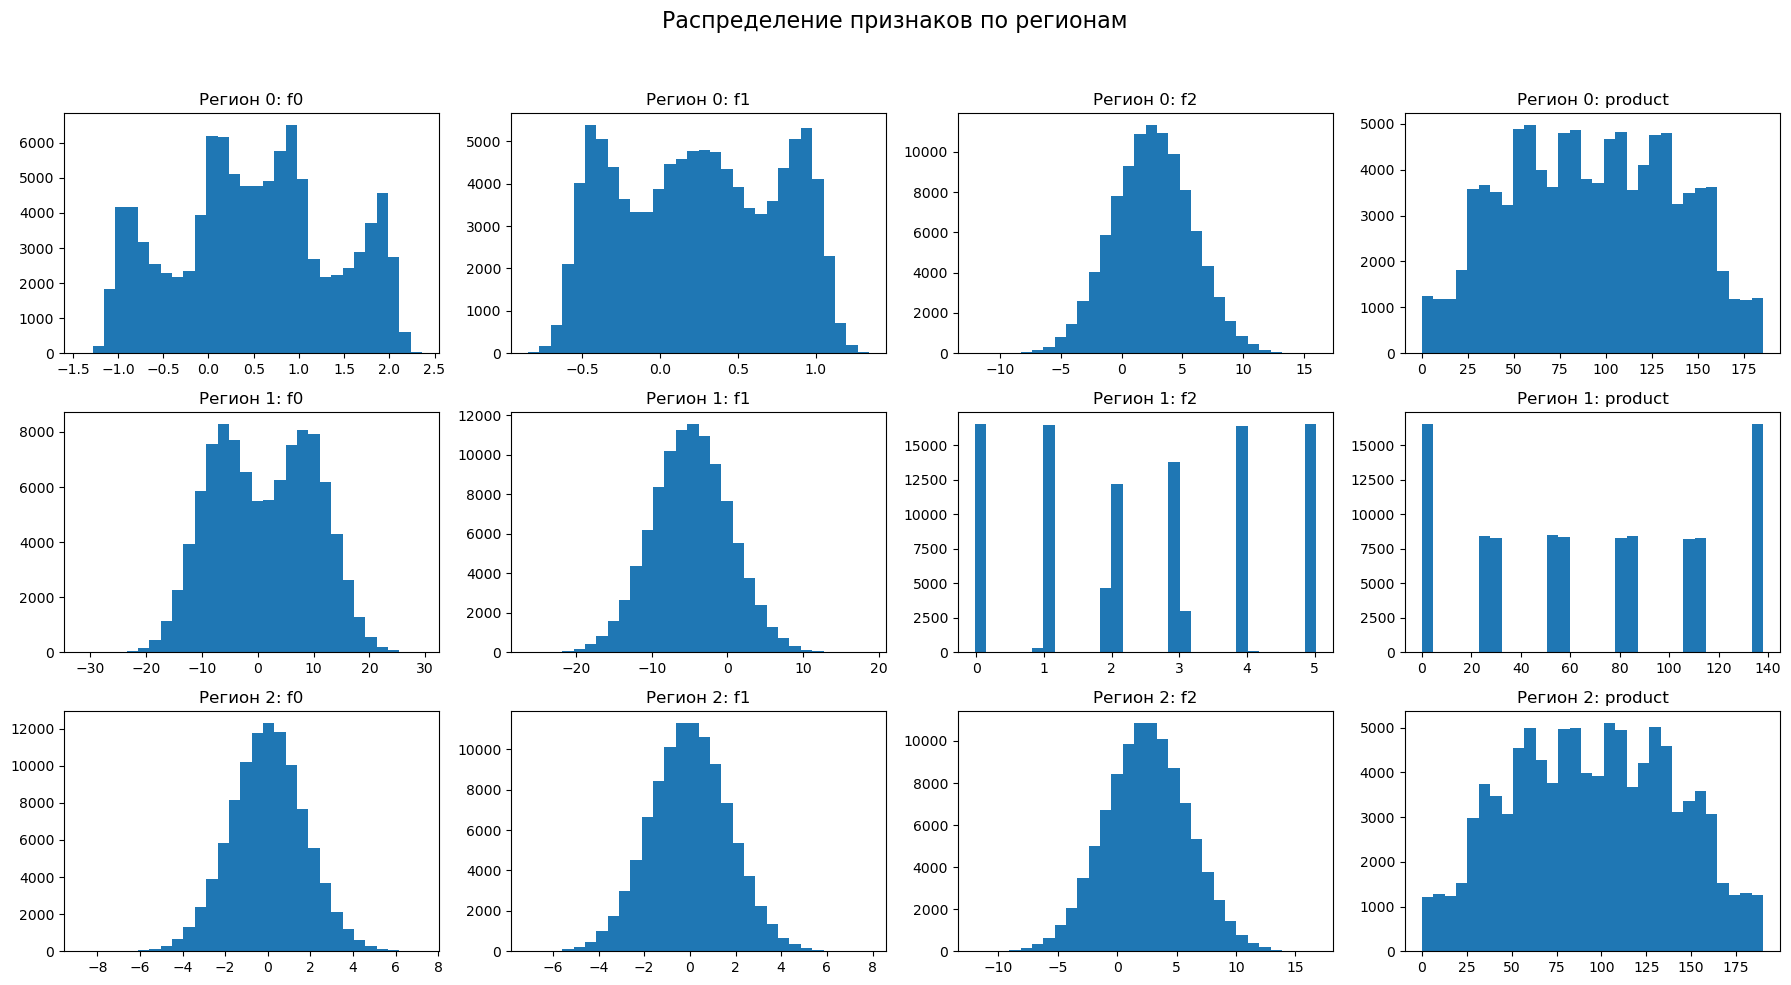

In [6]:
import matplotlib.pyplot as plt

datasets = {
    'Регион 0': data_1,
    'Регион 1': data_2,
    'Регион 2': data_3
}

features = ['f0', 'f1', 'f2', 'product']

fig, axes = plt.subplots(
    nrows=3, 
    ncols=4, 
    figsize=(18, 10)
)

for row, (region, df) in enumerate(datasets.items()):
    for col, feature in enumerate(features):
        axes[row, col].hist(df[feature], bins=30)
        axes[row, col].set_title(f'{region}: {feature}')
        
plt.suptitle('Распределение признаков по регионам', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Распределения признаков `f0` и `f1` во всех регионах имеют схожую форму и не содержат явных аномалий или выбросов.
Признак `f2` в регионах 0 и 2 распределён близко к нормальному, тогда как в регионе 1 имеет дискретный характер, что является особенностью данного датасета.

Распределение целевого признака `product` различается между регионами. Средние значения запасов в скважинах отличаются, что может существенно повлиять на потенциальную прибыль при выборе региона для разработки

В данных отсутствуют пропуски, типы данных корректны, распределения признаков адекватны для применения линейной регрессии. Существенных проблем качества данных не выявлено, что позволяет перейти к этапу построения модели.

## Обучение и проверка модели

Перейдем к обучению модели.

Для начала избавимся от столбца `id` в каждом из датасетов - для обучения он будет лишним.

In [7]:
data_1, data_2, data_3 = [
    df.drop(columns='id') for df in (data_1, data_2, data_3)
]

Обозначим признаки каждого датасета в переменные.

In [10]:
datasets = (data_1, data_2, data_3)

targets = []
features = []

for df in datasets:
    targets.append(df['product'])
    features.append(df.drop('product', axis=1))

target_1, target_2, target_3 = targets
features_1, features_2, features_3 = features

Не будем применять масштабирование, так как масштабы признаков сопоставимы, а также для линейной регресси оно необязательно.

In [13]:
# scaler_1 = StandardScaler()
# scaler_1.fit(features_1)
# features_1 = scaler_1.transform(features_1)

# scaler_2 = StandardScaler()
# scaler_2.fit(features_2)
# features_2 = scaler_2.transform(features_2)

# scaler_3 = StandardScaler()
# scaler_3.fit(features_3)
# features_3 = scaler_3.transform(features_3)

Поделим признаки на тренировочную и валидационную выборки с соотношением 75/25.

In [20]:
RANDOM_STATE = 42

In [17]:
from sklearn.model_selection import train_test_split


splits = [
    train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    for X, y in zip(
        (features_1, features_2, features_3),
        (target_1, target_2, target_3)
    )
]

(
    (features_train_1, features_valid_1, target_train_1, target_valid_1),
    (features_train_2, features_valid_2, target_train_2, target_valid_2),
    (features_train_3, features_valid_3, target_train_3, target_valid_3)
) = splits


Теперь перейдем непосредственно к обучению модели. Использовать будем модели линейной регрессии. Создадим 3 модели - для каждого датасета.

In [23]:
model_1 = LinearRegression() 
model_1.fit(features_train_1, target_train_1) 
predictions_valid_1 = model_1.predict(features_valid_1)

Также рассмотрим  показатель RMSE и среднее предсказание модели по датасету.

In [36]:
result_1 = np.sqrt(mean_squared_error(target_valid_1, predictions_valid_1))
print(f"RMSE первого региона: {result_1:.3f}")
print(f"Средний объем продукта в первом регионе: {predictions_valid_1.mean():.3f}")

#r2_1 = r2_score(target_valid_1, predictions_valid_1)
#print(r2_1)

RMSE первого региона: 37.757
Средний объем продукта в первом регионе: 92.399


В регионе 1 среднее предсказанное значение запасов составляет ~92.4 тыс. баррелей, при этом RMSE ~37.8 тыс. баррелей. Ошибка сопоставима с большой долей среднего уровня запасов, поэтому точность прогнозов умеренная: модель даёт общую оценку, но возможен заметный разброс фактических значений вокруг прогнозов. Регион нельзя оценивать только по точности — дальше критичны расчёт прибыли и рисков (Bootstrap).

Рассмотрим то же самое для второго и третьего датасетов.

In [37]:
model_2 = LinearRegression() 
model_2.fit(features_train_2, target_train_2) 
predictions_valid_2 = model_2.predict(features_valid_2)
result_2 = np.sqrt(mean_squared_error(target_valid_2, predictions_valid_2)) 

print(f"RMSE второго региона: {result_2:.3f}")
print(f"Средний объем продукта во втором регионе: {predictions_valid_2.mean():.3f}")

RMSE второго региона: 0.890
Средний объем продукта во втором регионе: 68.713


In [39]:
for i, df in enumerate((data_1, data_2, data_3), start=1):
    print(f'Регион {i}')
    print(df.corr(numeric_only=True)['product'].sort_values(ascending=False), end='\n\n')


Регион 1
product    1.000000
f2         0.483663
f0         0.143536
f1        -0.192356
Name: product, dtype: float64

Регион 2
product    1.000000
f2         0.999397
f1        -0.010155
f0        -0.030491
Name: product, dtype: float64

Регион 3
product    1.000000
f2         0.445871
f1        -0.001012
f0        -0.001987
Name: product, dtype: float64



Во 2-м регионе модель показывает значительно более высокую точность (RMSE ≈ 0.89 тыс. баррелей). Это объясняется особенностью данных: признак f2 имеет очень высокую корреляцию с целевым признаком product, то есть фактически содержит основную информацию о запасах. Поэтому линейная регрессия легко восстанавливает зависимость и даёт минимальную ошибку. При этом выбор региона для разработки всё равно будет определяться не только качеством модели, а ожидаемой прибылью и риском убытков по Bootstrap.

Третья модель:

In [38]:
model_3 = LinearRegression() 
model_3.fit(features_train_3, target_train_3) 
predictions_valid_3 = model_3.predict(features_valid_3)
result_3 = np.sqrt(mean_squared_error(target_valid_3, predictions_valid_3)) 

print(f"RMSE третьего региона: {result_3:.3f}")
print(f"Средний объем продукта в третьем регионе: {predictions_valid_3.mean():.3f}")

RMSE третьего региона: 40.146
Средний объем продукта в третьем регионе: 94.771


В регионе 3 среднее предсказание ~94.8 тыс. баррелей, RMSE ~40.1 тыс. баррелей. По уровню запасов регион близок к региону 1, но точность прогнозов также невысокая: ошибка велика относительно среднего значения. Поэтому для региона 3 особенно важно опираться не на RMSE, а на итоговые экономические метрики и риск убытков по Bootstrap.

Перейдем к следующему этапу.

## Подготовка к расчёту прибыли

Все ключевые значения сохраним в отдельных переменных.

In [46]:
TOTAL_SPENDS = 10000000000 # 10 млрд рублей
REVENUE_PER_UNIT  = 450000
POINTS_FOR_EXPLORATION = 500
POINTS_FOR_DEVELOPMENT = 200
MAX_PERCENT_OF_LOSS = 0.025

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

Для начала найдем порог убытков для одной скважины.

In [47]:
spends_per_point = TOTAL_SPENDS / POINTS_FOR_DEVELOPMENT
spends_per_point

50000000.0

50 млн рублей - это минимальная сумма, которую должна окупить одна скважина, чтобы не остаться в минусе.

Теперь посмотрим, сколько это в количестве нефти. Поделим это число на стоимость единицы одной единицы продукта.

In [48]:
spends_per_point / REVENUE_PER_UNIT 

111.11111111111111

111 тысяч баррелей - минимальный объем нефти в скважине, при котором расходы на нее окупаются. 

Безубыточный объём для одной скважины составляет около 111 тыс. баррелей. Он выше среднего запаса по регионам, поэтому при случайном выборе скважин легко получить убыток. Следовательно, необходимо отбирать лучшие 200 скважин на основе прогнозов модели и далее оценивать прибыль и риски методом Bootstrap.

Напишем функцию для расчета прибыли. В качестве аргументов она будет принимать правильные значения целевого признака (target), предсказанные значения целевого признака (predictions) и само количество объектов (в нашем случаее 200).

In [49]:
def revenue(target, predictions, count):
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]
    return REVENUE_PER_UNIT  * selected.sum() - TOTAL_SPENDS

Отбираем 200 скважин с максимальными прогнозными запасами, а прибыль считаем по фактическим значениям `product` для выбранных скважин. Это имитирует процесс принятия решения по прогнозу и проверку результата по реальным данным.

Применять эту функцию будем в рамках бутстрапа на следующем этапе.

## Расчёт прибыли и рисков 

Перед бутстрапом переоформим предсказания в Series, а индексы сбросим. Это нужно, чтобы синхронизировать индексы.

In [50]:
targets = [target_valid_1.reset_index(drop=True),
           target_valid_2.reset_index(drop=True),
           target_valid_3.reset_index(drop=True)]

preds = [pd.Series(p, index=t.index) for p, t in zip(
    (predictions_valid_1, predictions_valid_2, predictions_valid_3),
    targets
)]

target_valid_1, target_valid_2, target_valid_3 = targets
predictions_valid_1, predictions_valid_2, predictions_valid_3 = preds


Теперь создадим функцию расчета необходимых показателей методом бустрапа. В рамках нее используем предыдущую функцию расчета прибыли.

Смоделируем ситуацию где из 500 неизвестных нам скважин на основании прогнозов модели находим 200 лучших и посмотрим реальную прибыль, которую эти скважины принесут при учете, что у них такое же распределение, как у остальных скважин в регионе. 

Помимо средней прибыли найдем также 95-доверительный интервал и вероятность убытков.

In [57]:
def bootstrap_profit(target, predictions,
                     n_bootstrap=1000,
                     n_explore=POINTS_FOR_EXPLORATION,
                     n_develop=POINTS_FOR_DEVELOPMENT,
                     seed=RANDOM_STATE,
                     show_plot=True,
                     bins=30):

    predictions = pd.Series(predictions, index=target.index)

    rng = np.random.RandomState(seed)

    values = []
    for _ in range(n_bootstrap):
        subsample = target.sample(n=n_explore, replace=True, random_state=rng)

        preds_sub = predictions.loc[subsample.index]

        values.append(revenue(subsample, preds_sub, n_develop))

    values = pd.Series(values)

    mean_profit = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean()

    if show_plot:
        plt.figure(figsize=(10, 5))
        plt.hist(values, bins=bins)
        plt.axvline(lower, color='red')
        plt.axvline(upper, color='red')
        plt.axvline(0, color='black')  # граница убытков
        plt.axvline(mean_profit, color='green')  # средняя прибыль
        plt.title('Распределение прибыли (Bootstrap)')
        plt.grid(True)
        plt.show()

    return mean_profit, lower, upper, risk, values


Рассмотрим функцию для всех регионов.

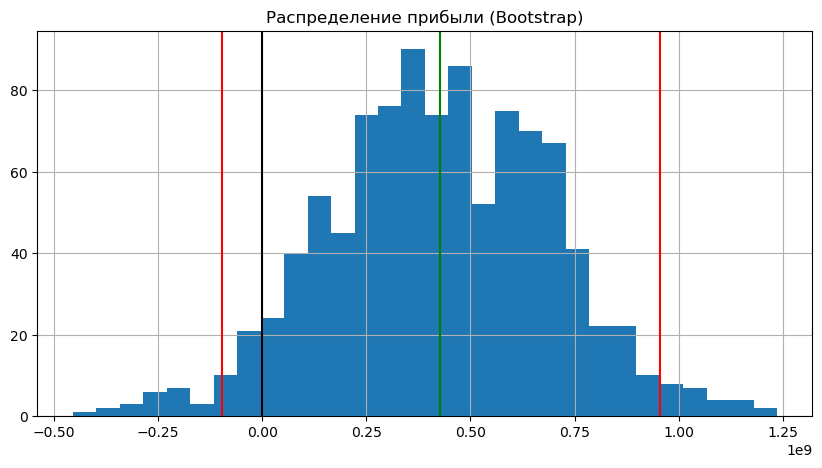

Средняя прибыль: 427.8 млн руб.
95% ДИ: [-97.2, 954.2] млн руб.
Риск убытков: 5.50%


In [59]:
mean_profit, lower, upper, risk, values = bootstrap_profit(target_valid_1, predictions_valid_1)

print(f'Средняя прибыль: {mean_profit/1e6:,.1f} млн руб.')
print(f'95% ДИ: [{lower/1e6:,.1f}, {upper/1e6:,.1f}] млн руб.')
print(f'Риск убытков: {risk:.2%}')


По результатам Bootstrap средняя прибыль положительная (~427 млн руб.), однако 95% доверительный интервал включает отрицательные значения (до ~−97 млн руб.), а риск убытков составляет ~5.5%, что превышает допустимый порог 2.5%. Следовательно, регион не удовлетворяет условию по рискам.

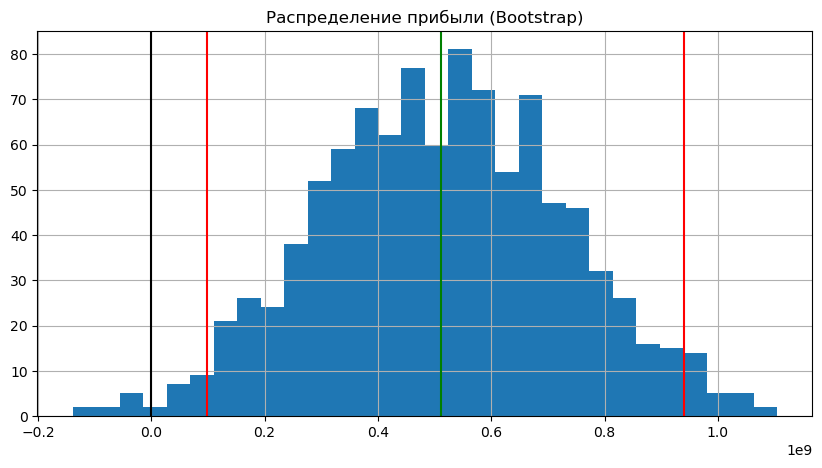

Средняя прибыль: 511.4 млн руб.
95% ДИ: [98.9, 940.7] млн руб.
Риск убытков: 0.90%


In [60]:
mean_profit, lower, upper, risk, values = bootstrap_profit(target_valid_2, predictions_valid_2)

print(f'Средняя прибыль: {mean_profit/1e6:,.1f} млн руб.')
print(f'95% ДИ: [{lower/1e6:,.1f}, {upper/1e6:,.1f}] млн руб.')
print(f'Риск убытков: {risk:.2%}')

Регион 2 показывает отличный результат по рискам: вероятность убытков составляет ~0.9%, что ниже порогового значения 2.5%. Средняя ожидаемая прибыль по Bootstrap — около 511 млн руб., а 95% доверительный интервал полностью положительный (примерно от 90 млн до 947 млн руб.). Следовательно, регион удовлетворяет условию по рискам и является кандидатом на разработку.

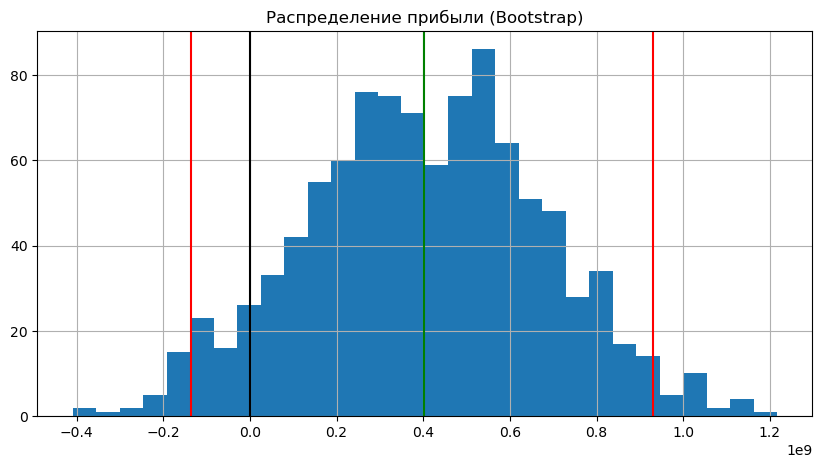

Средняя прибыль: 402.6 млн руб.
95% ДИ: [-137.2, 929.9] млн руб.
Риск убытков: 7.40%


In [61]:
mean_profit, lower, upper, risk, values = bootstrap_profit(target_valid_3, predictions_valid_3)

print(f'Средняя прибыль: {mean_profit/1e6:,.1f} млн руб.')
print(f'95% ДИ: [{lower/1e6:,.1f}, {upper/1e6:,.1f}] млн руб.')
print(f'Риск убытков: {risk:.2%}')

По результатам Bootstrap для Региона 3 средняя ожидаемая прибыль составляет около 402,6 млн руб. Однако 95% доверительный интервал включает отрицательные значения (примерно от −137,2 млн до 929,9 млн руб.), а риск убытков ~7,4%, что превышает допустимый порог 2,5%. Следовательно, Регион 3 не удовлетворяет условию по рискам и не может быть выбран для разработки.

**Итоговый вывод по всем регионам**:

- Регион 1: средняя прибыль положительная, но 95% ДИ включает отрицательные значения, риск убытков около 5,5% → не проходит порог 2,5%.

- Регион 2: средняя прибыль около 511,4 млн руб., 95% ДИ полностью положительный, риск убытков около 0,9% → проходит порог 2,5%.

- Регион 3: средняя прибыль около 402,6 млн руб., 95% ДИ включает отрицательные значения, риск убытков около 7,4% → не проходит порог 2,5%.

С учётом требования “оставить регионы с риском < 2,5% и выбрать среди них максимальную среднюю прибыль”, оптимальным выбором является Регион 2, так как он единственный проходит по риску и при этом имеет наибольшую среднюю ожидаемую прибыль среди допустимых.

## Вывод

В ходе проекта была решена задача выбора региона для бурения скважин с максимальной ожидаемой прибылью при ограничении по риску убытков. Работа выполнена в несколько этапов:

**1. Подготовка и первичный анализ данных.**
Загружены данные по трём регионам, проверены типы, пропуски и корректность структуры. Для дальнейшего моделирования исключён столбец id, так как он является идентификатором и не несёт полезной информации для предсказания. Проведён обзор распределений признаков и целевого признака, а также анализ корреляций — во 2-м регионе обнаружена сильная связь f2 и product, что объясняет высокую предсказуемость данных.

**2. Обучение и оценка модели.**
Для каждого региона данные были разделены на обучающую и валидационную выборки в пропорции 75:25 с фиксированным random_state. Обучена модель линейной регрессии, получены предсказания на валидации, рассчитаны метрики (RMSE и среднее предсказанное значение запасов). Для 2-го региона качество модели оказалось существенно выше, что согласуется с результатами анализа исходных данных.

**3. Подготовка к расчёту прибыли.**
Зафиксированы ключевые параметры задачи: бюджет 10 млрд руб., доход 450 тыс. руб. за 1 тыс. баррелей, 500 точек разведки и 200 скважин для разработки. Рассчитан безубыточный объём сырья на одну скважину (~111 тыс. баррелей), что выше среднего уровня запасов по регионам. Это подтверждает необходимость отбора лучших скважин по прогнозам модели, а не случайного выбора.

**4. Расчёт прибыли и оценка рисков (Bootstrap).**
Реализована функция расчёта прибыли по выбранным скважинам: сначала выбираются 200 скважин с максимальными прогнозами, а прибыль считается по фактическим запасам этих скважин. Далее методом Bootstrap (1000 выборок) смоделированы сценарии разведки: из 500 случайных точек выбирались 200 лучших, считалась прибыль, после чего определялись средняя прибыль, 95% доверительный интервал и риск убытков (доля отрицательной прибыли).

**5. Финальное решение.**
По результатам Bootstrap Регионы 1 и 3 имеют риск убытков выше допустимых 2.5% (доверительный интервал включает отрицательные значения), поэтому не проходят условие по рискам. Регион 2 демонстрирует риск убытков ниже 2.5% и наибольшую среднюю ожидаемую прибыль среди допустимых вариантов. Следовательно, для разработки рекомендуется Регион 2, так как он удовлетворяет ограничению по риску и обеспечивает максимальную ожидаемую прибыль.